# Dependencies and files

## Install dependencies

## Imports

In [5]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [6]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [7]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [8]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [9]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [10]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [11]:
pb_dir_path = '../../data/pseudobulks/'

In [12]:
os.listdir(pb_dir_path)

['4spe_pb_mean_filt.h5ad',
 '4spe_pb_mean_filt_nor_mean.h5ad',
 'pb_age.h5ad',
 'pb_mammals.h5ad',
 'pb_mammals_filtered.h5ad',
 'pb_mammals_samplenorm_mean.h5ad',
 'pb_mammals_samplenorm_zscore.h5ad']

In [13]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 9208
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [14]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

9208

## Specie-specific genes

In [15]:
import pickle
with open("./results/specie_specific_genes_tr67.pkl", "rb") as file:
    genes_dict77 = pickle.load(file)

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [19]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [20]:
hs_genes = genes_dict77['human']

In [21]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

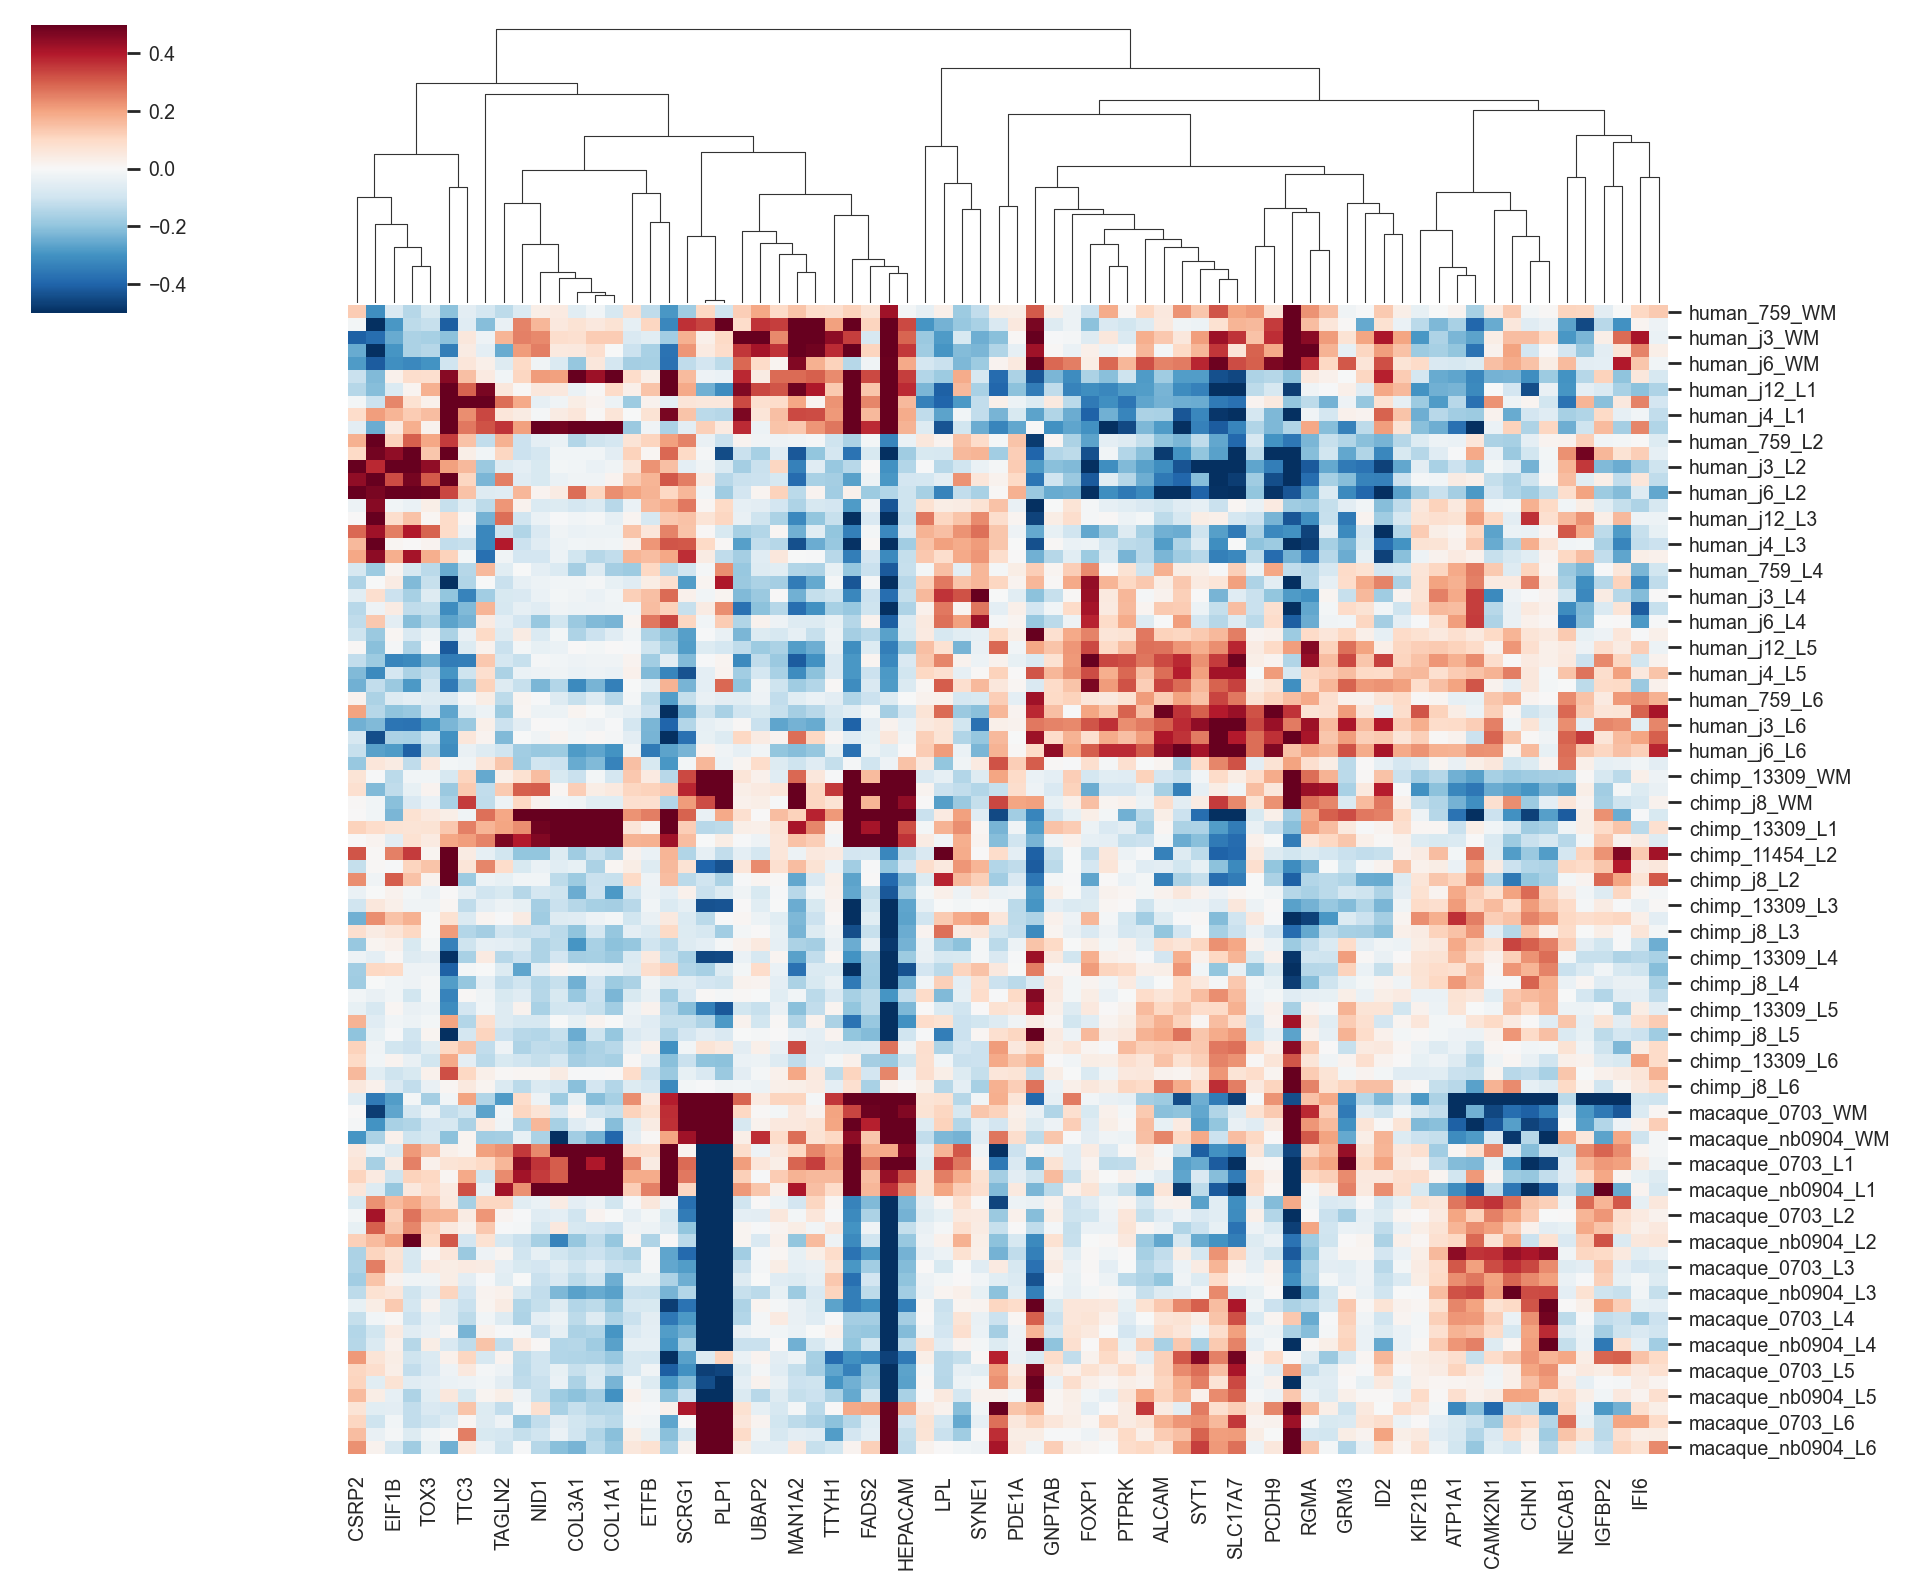

In [22]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.5, vmin=-0.5, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [24]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.loc[sample_order['human']].T, metric='cosine') + 1
n_clusters = 3
clustering = SpectralClustering(n_clusters=n_clusters, gamma=1, affinity='precomputed', random_state=4)
clustering.fit(aff_matrix)

SpectralClustering(affinity='precomputed', gamma=1, n_clusters=3,
                   random_state=4)

In [25]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [26]:
labels.to_csv('./results/human_clusters_67.csv')

In [29]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [30]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

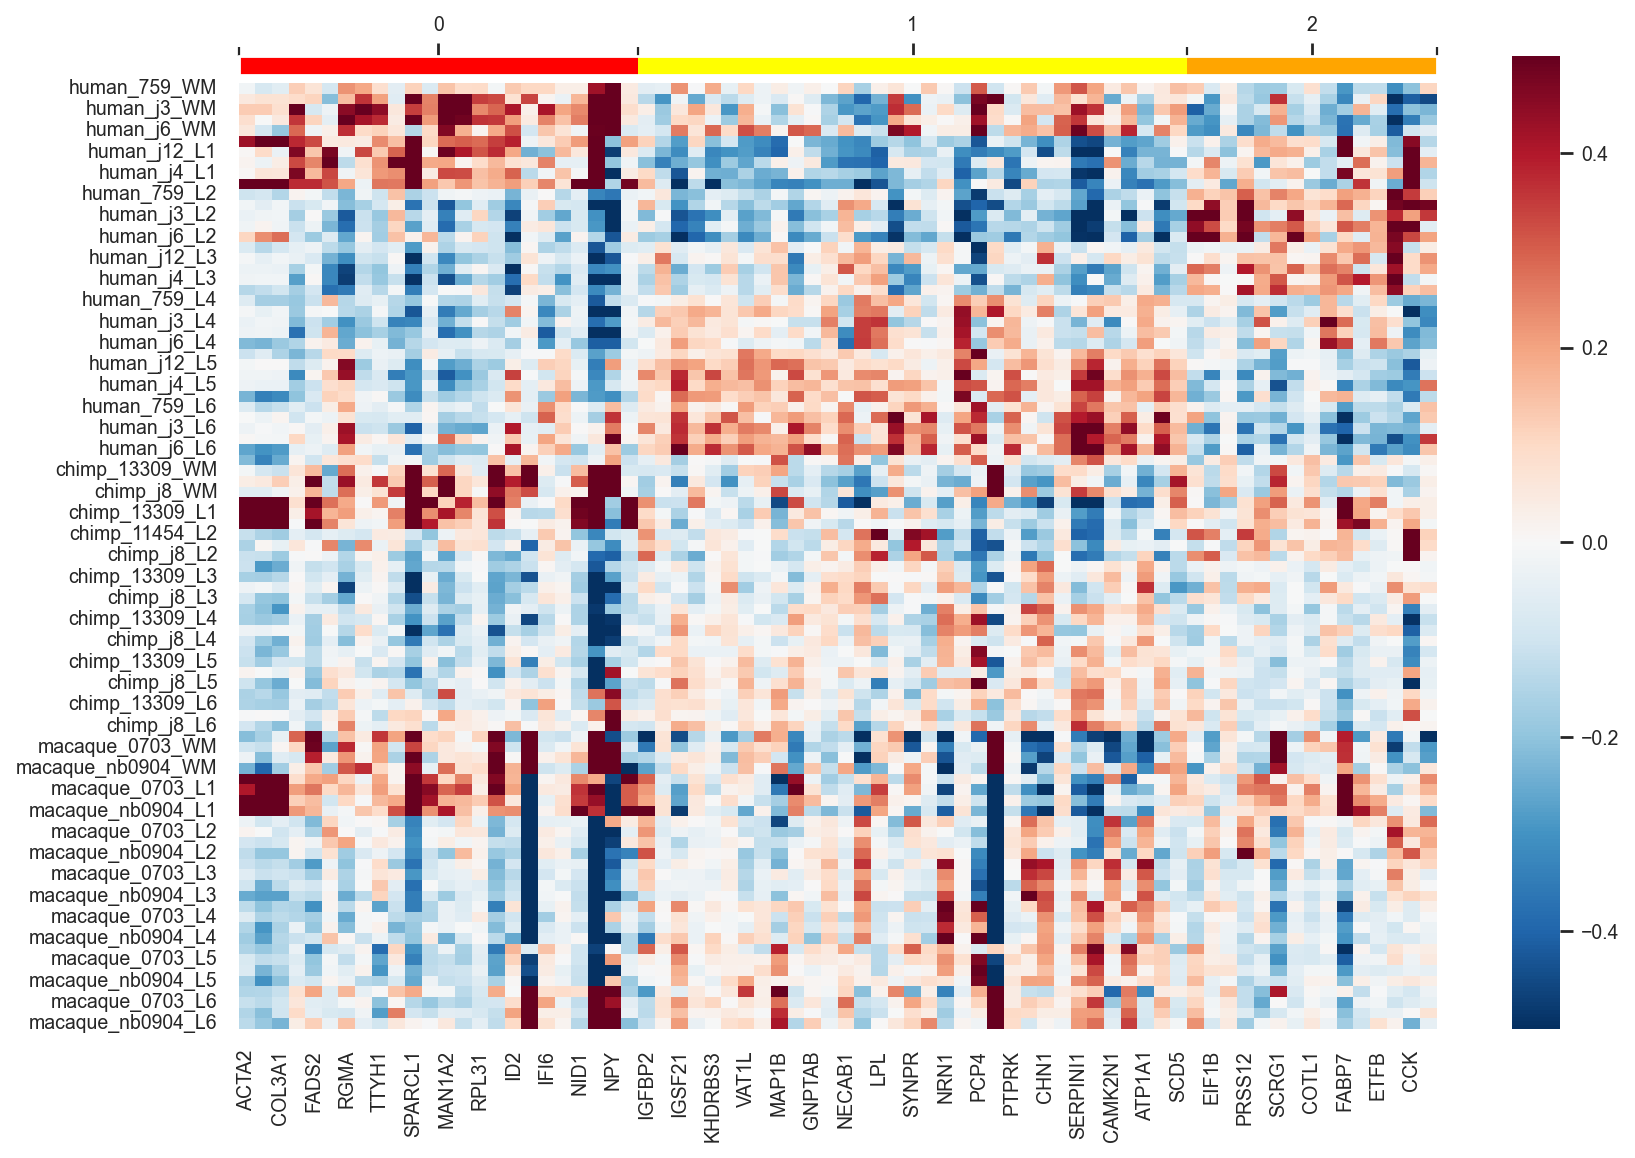

In [31]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.5, vmin=-0.5, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

## Cluster profiles

In [32]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [33]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ACTA2     ALCAM    ATP1A1      BPTF   CAMK2N1       CCK  \
condition layer                                                               
chimp     L1     0.728220  0.009130 -0.184461  0.035123 -0.065439  0.120394   
          L2    -0.127487 -0.242804  0.021539  0.002007 -0.058096  0.544792   
          L3    -0.095616 -0.066325  0.229186 -0.006032  0.075883  0.075539   
          L4    -0.111591  0.006249  0.163216 -0.000353  0.029098 -0.380507   
          L5    -0.077636  0.134409  0.025389 -0.017713  0.012825 -0.238573   

                     CHN1    COL1A1    COL3A1     COTL1  ...     SYNE1  \
condition layer                                          ...             
chimp     L1    -0.251971  1.001097  1.059301  0.153622  ... -0.011624   
          L2    -0.175803 -0.086257 -0.133595  0.053160  ...  0.096819   
          L3     0.221780 -0.166006 -0.162551 -0.092904  ...  0.077937   
          L4     0.247662 -0.150373 -0.180821 -0.122691  ...  0.052186   
          L5     0.088004 -0.148761 -0.141695 -0.055447  ...  0.001706   

                    SYNPR      SYT1    TAGLN2      TOX3      TTC3     TTYH1  \
condition layer                                                               
chimp     L1    -0.027984 -0.246676  0.287728  0.054988  0.146501  0.071092   
          L2     0.351966 -0.098037 -0.016191  0.059883 -0.025527  0.014022   
          L3     0.050307 -0.000879 -0.053854 -0.014090 -0.097487  0.005924   
          L4    -0.069912  0.042413 -0.094862 -0.025821 -0.118147 -0.032925   
          L5    -0.088597  0.097851 -0.079813 -0.010624 -0.079551 -0.050280   

                    UBAP2     VAT1L    ZBTB18  
condition layer                                
chimp     L1     0.001697 -0.134595 -0.154330  
          L2     0.053347 -0.027984  0.229193  
          L3    -0.041216 -0.090556  0.178206  
          L4     0.017843 -0.019777  0.129230  
          L5    -0.056467  0.138460  0.023022  

[5 rows x 72 columns]

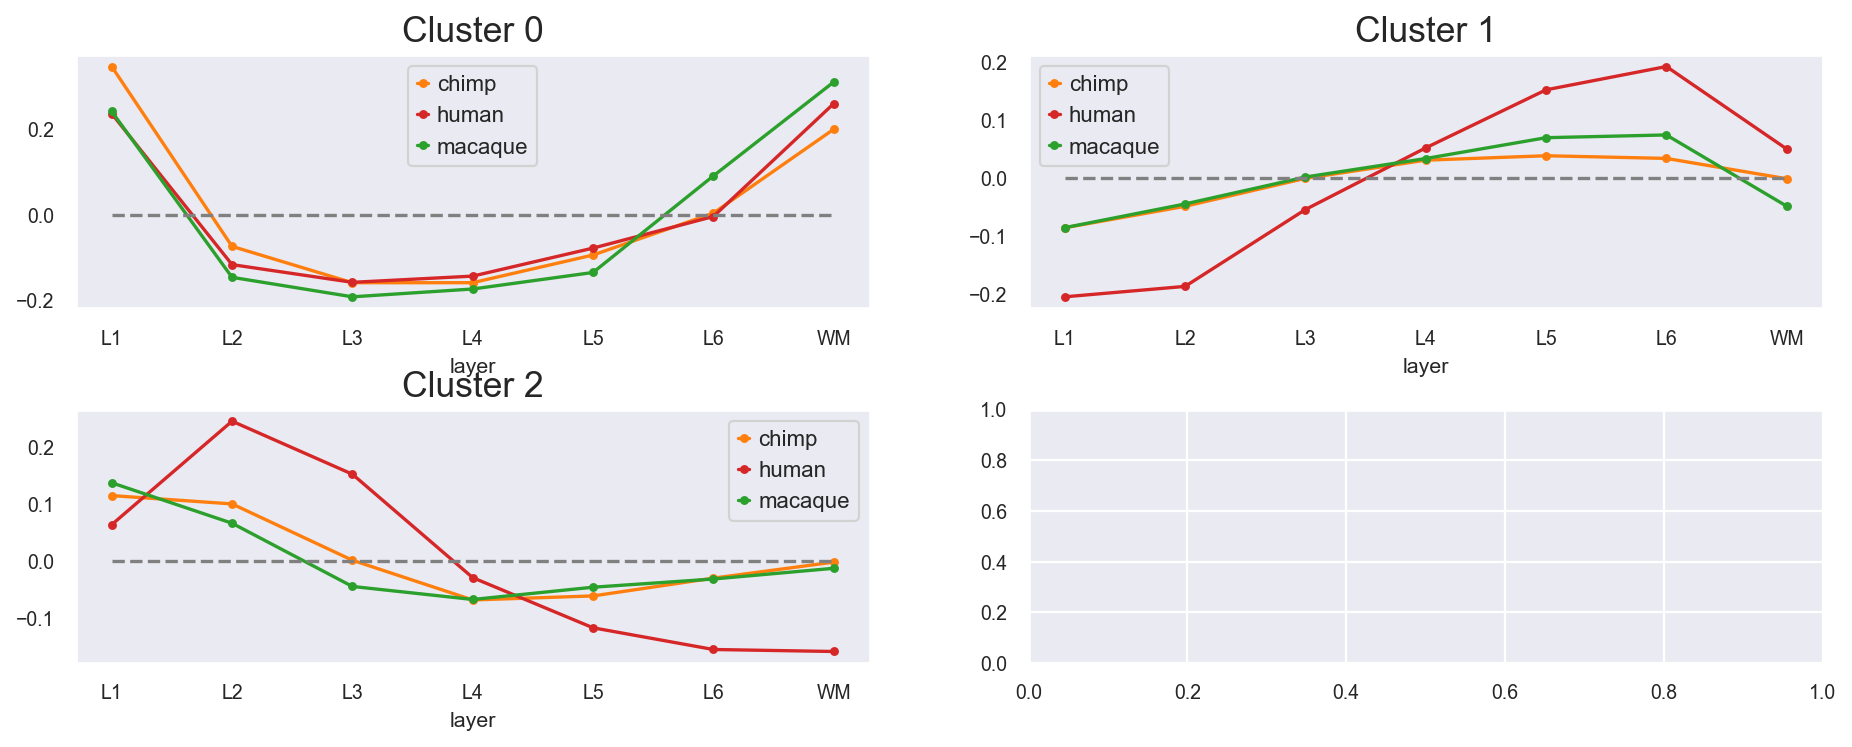

In [34]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

# Intersection with ANOVA clusters

In [35]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ACTA2', 'ALCAM', 'ATP1A1', 'BPTF', 'CAMK2N1', 'CCK', 'CHN1', 'COL1A1',
       'COL3A1', 'COTL1', 'CSPG5', 'CSRP2', 'DCLK1', 'EIF1B', 'ENC1', 'ETFB',
       'FABP7', 'FADS2', 'FAM171B', 'FOXP1', 'GAD1', 'GFAP', 'GNAZ', 'GNPTAB',
       'GRM3', 'HEPACAM', 'ID2', 'IFI6', 'IGFBP2', 'IGSF21', 'KHDRBS3',
       'KIF21B', 'KLF6', 'LHX2', 'LPL', 'MAN1A2', 'MAP1B', 'MBP', 'MGP',
       'NCAM2', 'NECAB1', 'NID1', 'NRN1', 'OPRK1', 'PCDH9', 'PCP4', 'PDE1A',
       'PLP1', 'PRSS12', 'PTPRK', 'RGMA', 'RGS4', 'RPL12', 'RPL31', 'SCD5',
       'SCG2', 'SCRG1', 'SERPINI1', 'SLC17A7', 'SLC2A1', 'SYNE1', 'SYNPR',
       'SYT1', 'TAGLN2', 'TOX3', 'TTC3', 'TTYH1', 'UBAP2', 'VAT1L', 'ZBTB18'],
      dtype='object')

In [36]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels,0,1,2
ANOVA_labels,,,
0,0.0,0.0,12.0
1,1.0,4.0,1.0
2,0.0,20.0,0.0
3,2.0,1.0,1.0
4,2.0,0.0,0.0
5,1.0,6.0,0.0
6,16.0,2.0,1.0


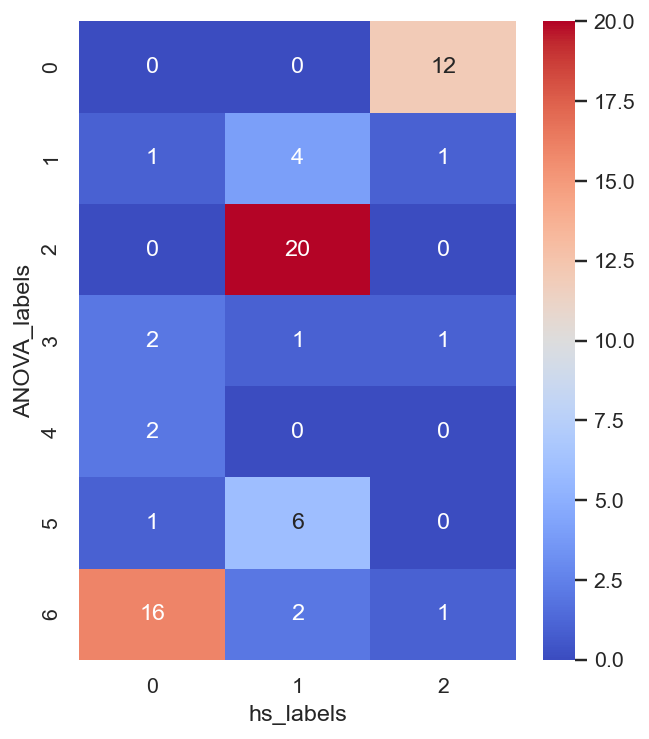

In [39]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

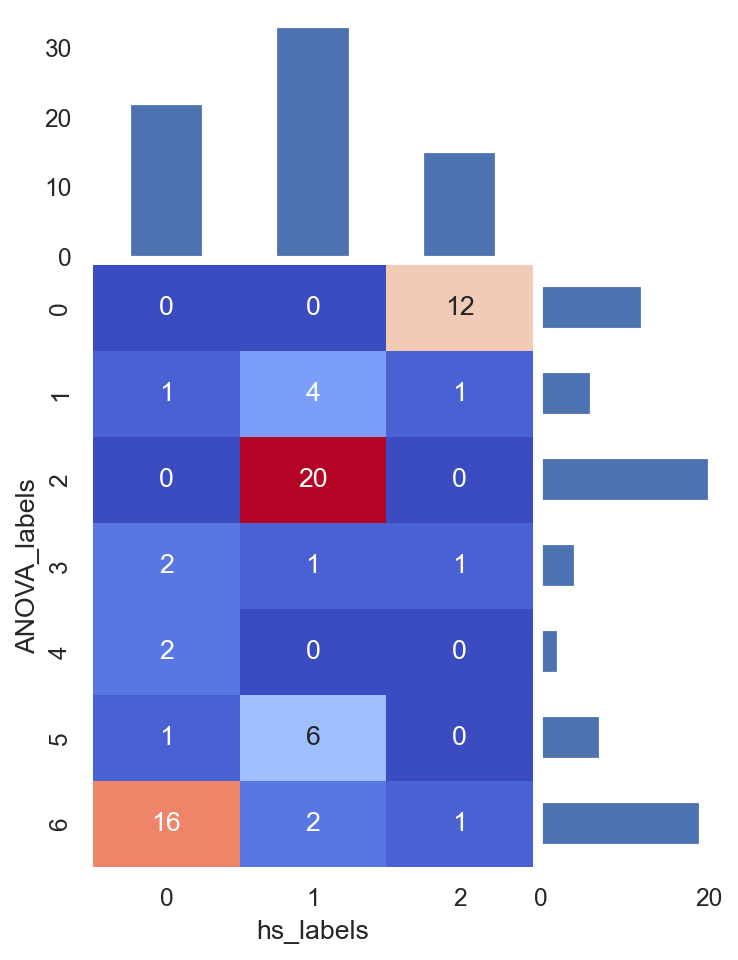

In [40]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', center=10, fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [41]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/3 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [42]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [43]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
external encapsulating structure organization (GO:0045229),1,0.000825,18.871636,133.999104,"[COL1A1, COL3A1, NID1]",0.074246,0,0,3,1.12933,0
extracellular structure organization (GO:0043062),2,0.000859,18.600000,131.321588,"[COL1A1, COL3A1, NID1]",0.074246,0,0,3,1.12933,0
skin development (GO:0043588),3,0.001457,41.654545,272.064797,"[COL1A1, COL3A1]",0.074246,0,0,2,1.12933,0
disaccharide biosynthetic process (GO:0046351),4,0.002606,inf,inf,[SLC2A1],0.074246,0,0,1,1.12933,0
extracellular matrix organization (GO:0030198),5,0.002655,12.352381,73.267854,"[COL1A1, COL3A1, NID1]",0.074246,0,0,3,1.12933,0


In [47]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

0

In [45]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13700\2866965372.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


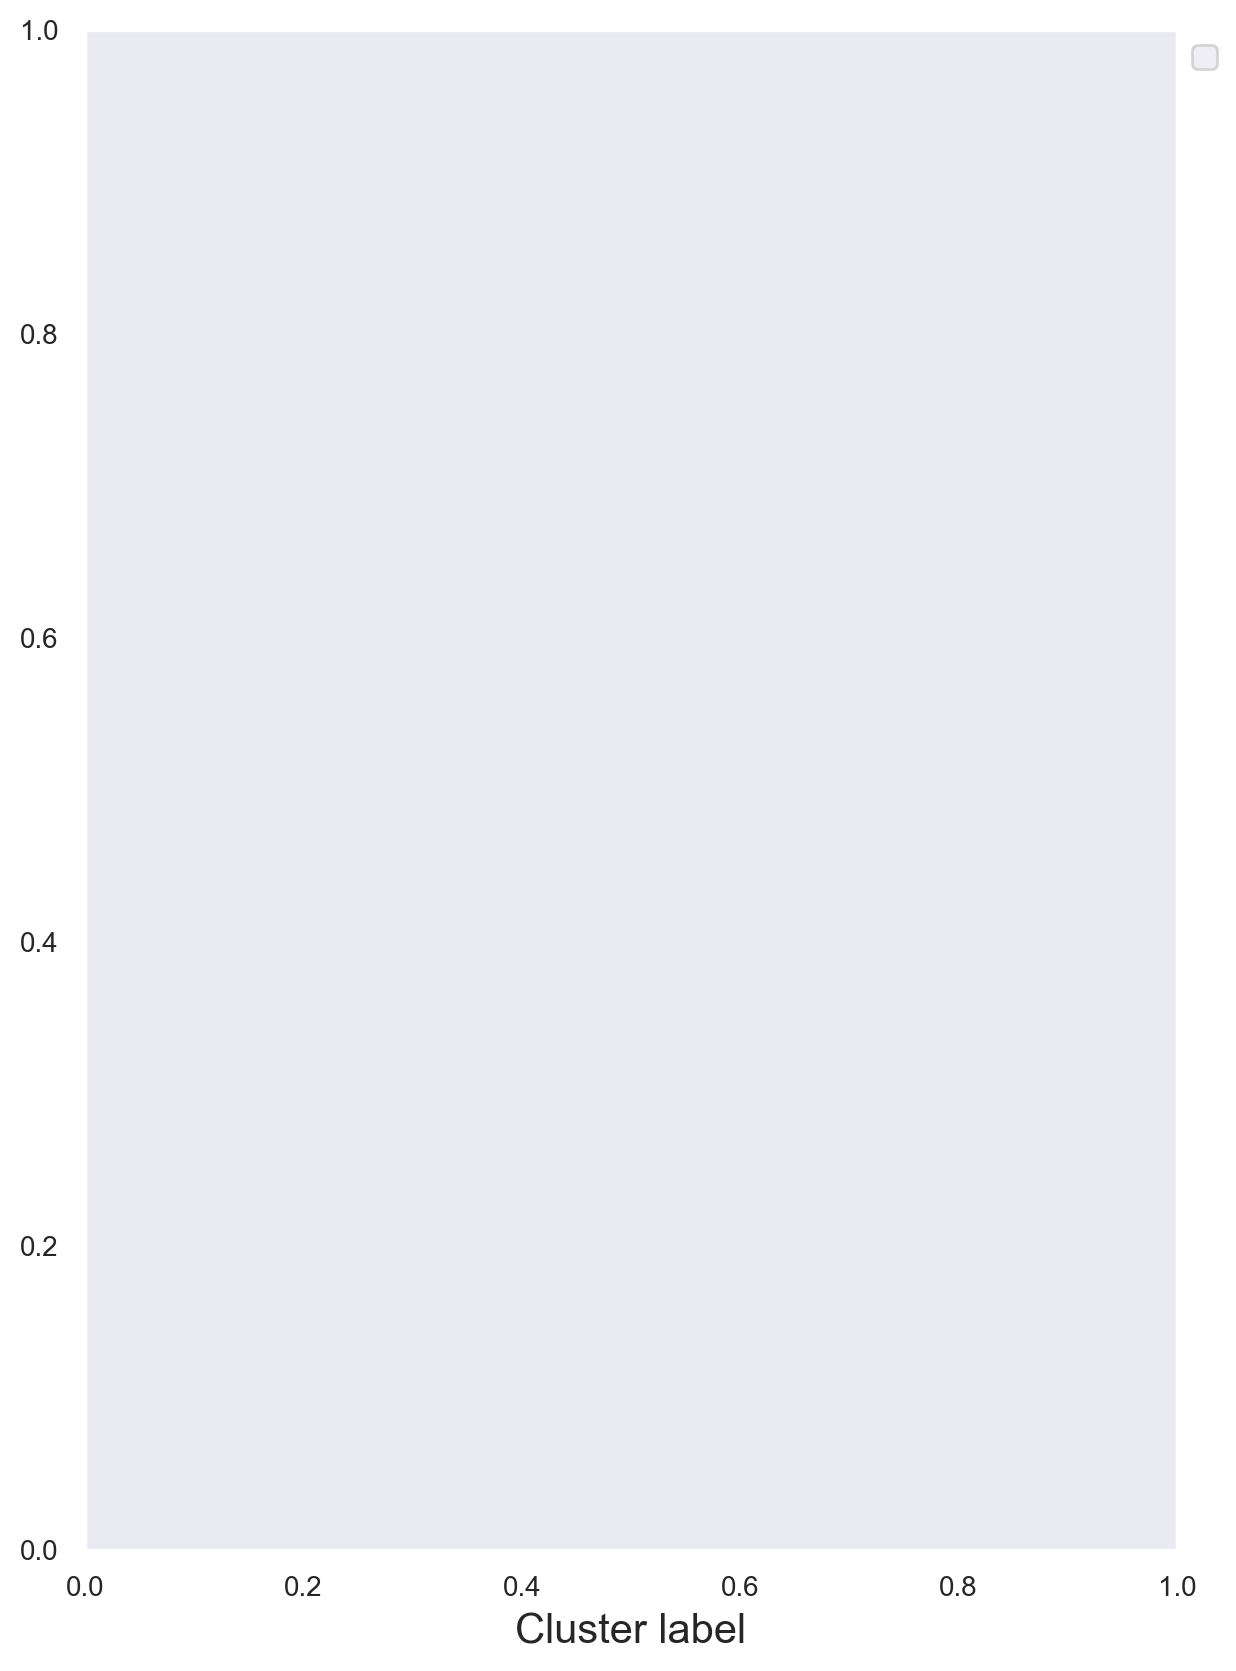

In [46]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [48]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [49]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Activated Stellate CL0002410,1,0.000136,166.890909,1486.244520,"[COL1A1, COL3A1]",0.001628,0,0,2,2.788422,0
Myofibroblast CL0000186,2,0.000136,166.890909,1486.244520,"[COL1A1, COL3A1]",0.001628,0,0,2,2.788422,0
SST+ NPY+ Layer 1-6 GABAergic Neuron CL0000617,3,0.007800,199.608696,968.835221,[NPY],0.021569,0,0,1,1.666180,0
Sst+ Chodl+ GABAergic Neuron CL0000617,4,0.007800,199.608696,968.835221,[NPY],0.021569,0,0,1,1.666180,0
FGFR3+ AQP1+ Layer 1-6 Astrocyte CL0000127,5,0.010387,133.057971,607.707430,[GFAP],0.021569,0,0,1,1.666180,0


In [50]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

27

In [51]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

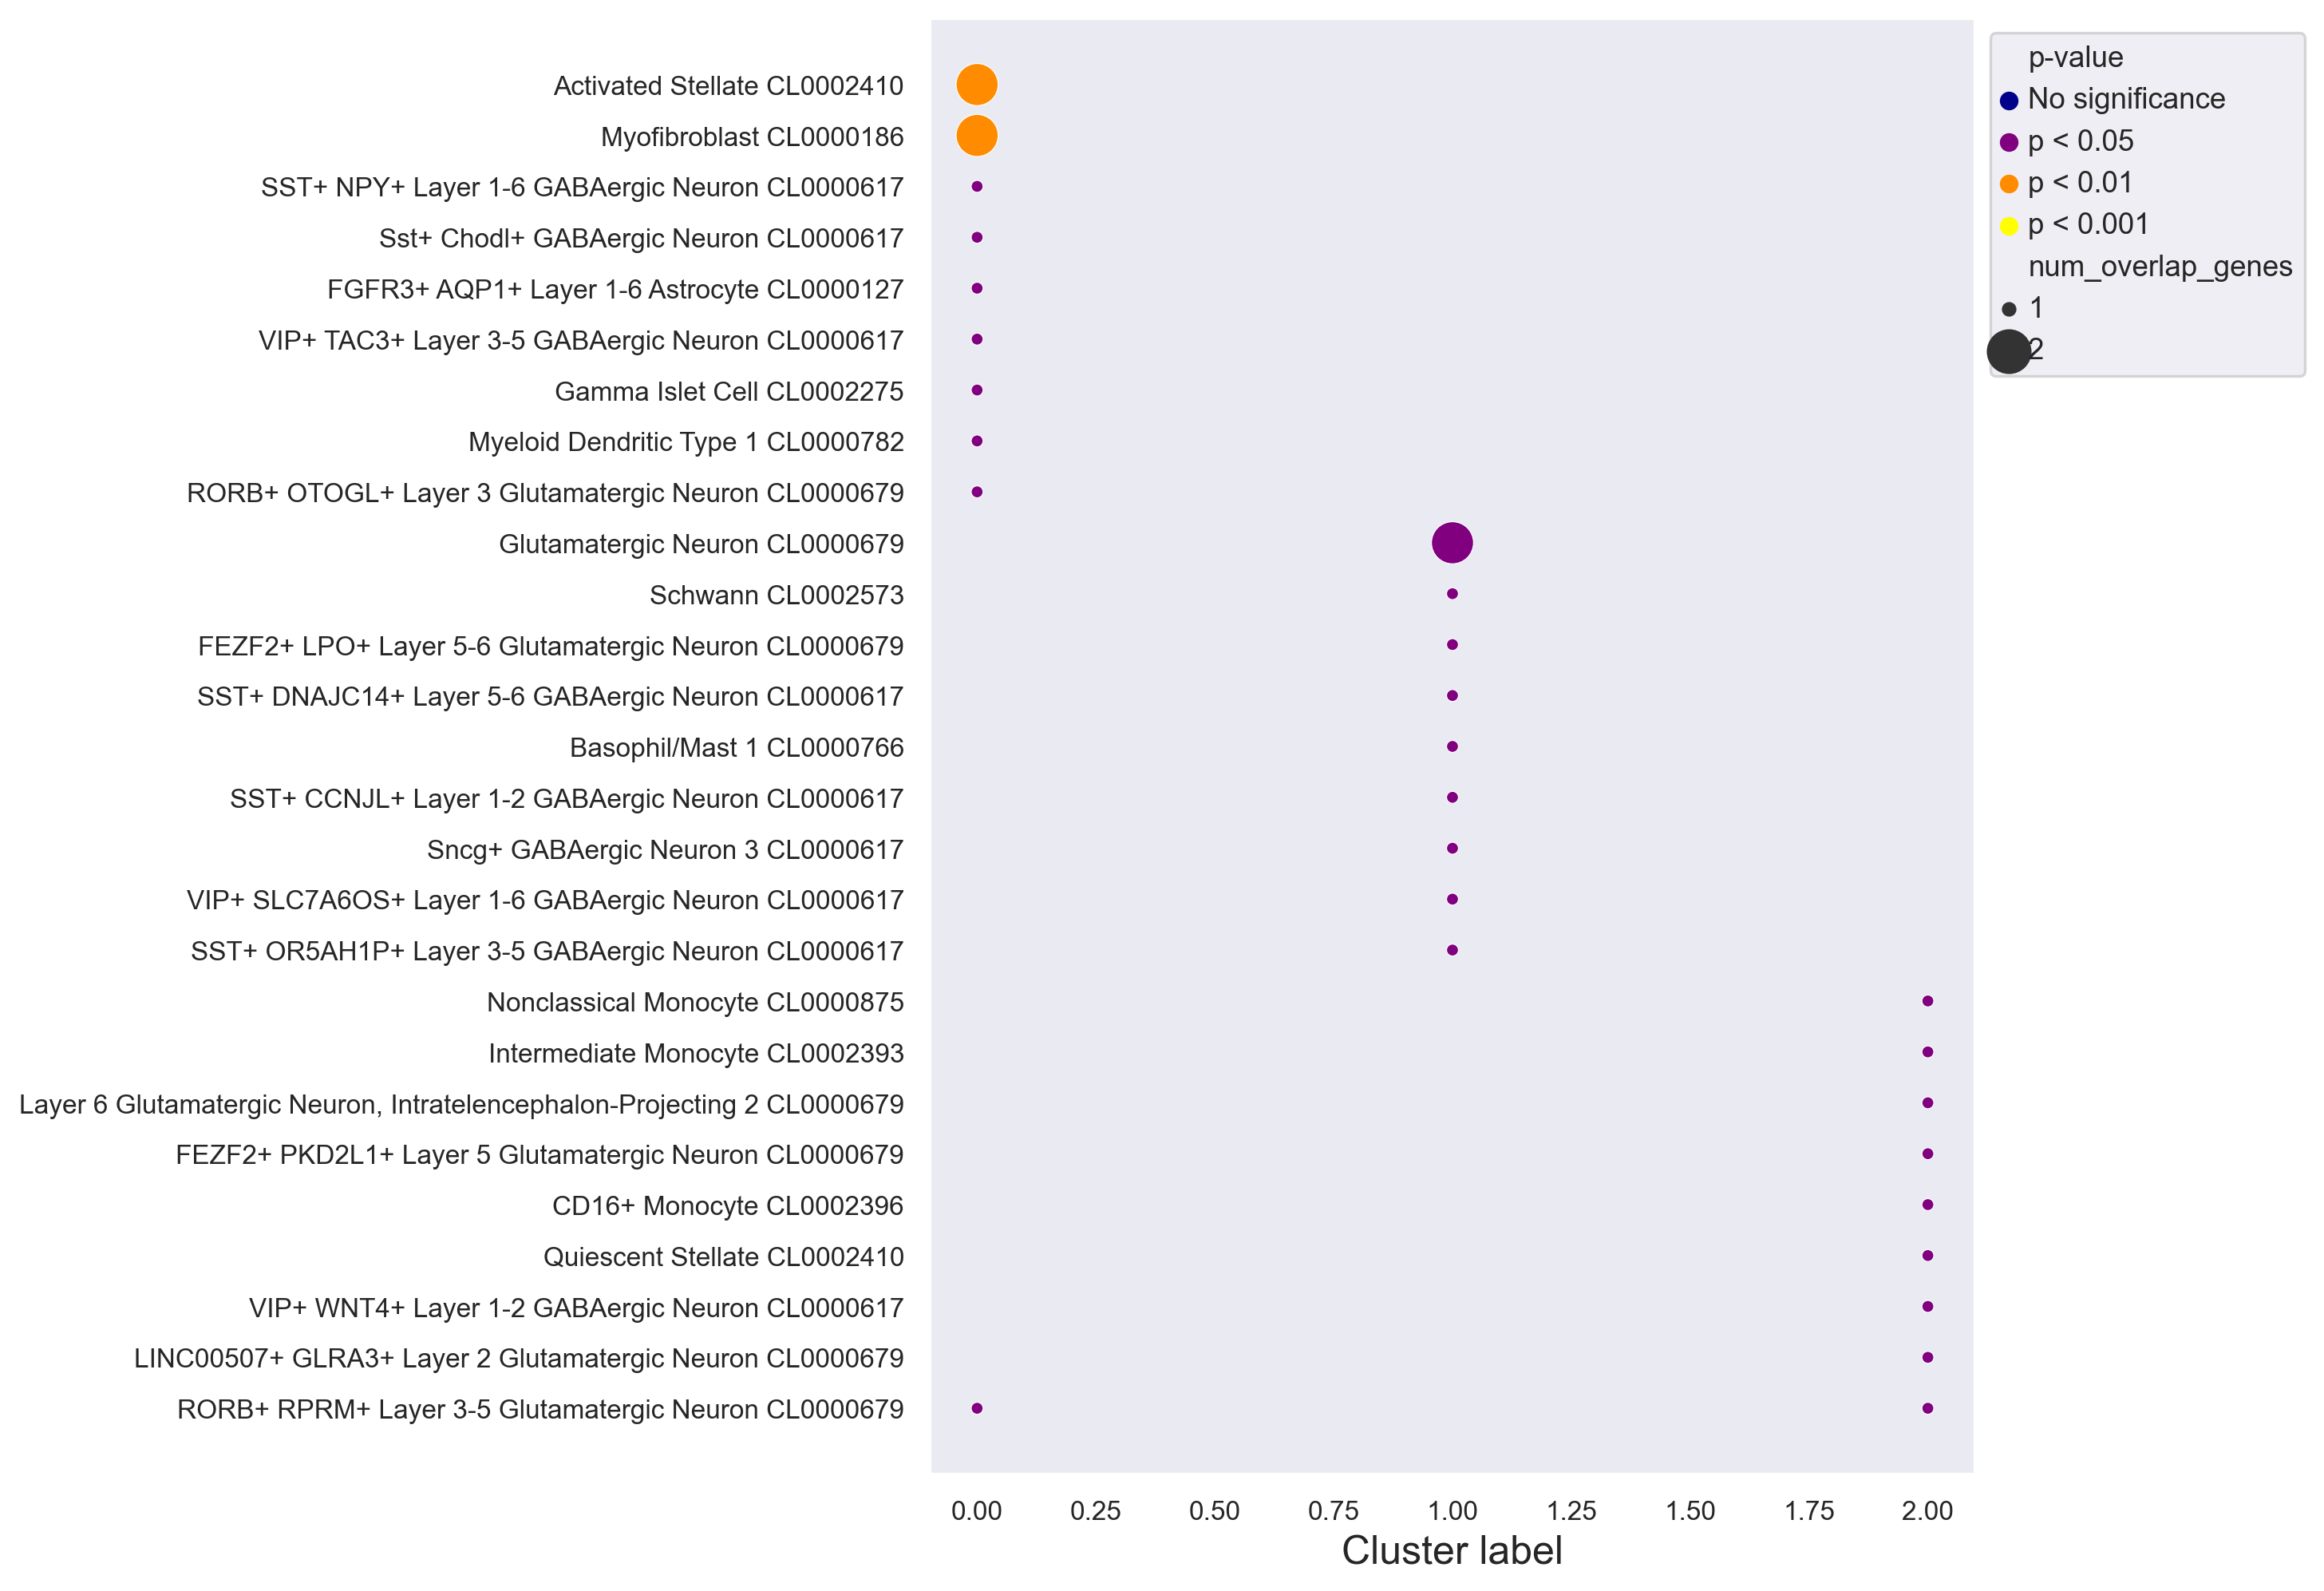

In [52]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [53]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [54]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
sporadic seizures MP:0000951,1,1.672454e-07,114.600000,1788.195865,"[NPY, SLC2A1, MBP, NID1]",0.000068,0,0,4,4.164848,0
abnormal aorta elastic tissue morphology MP:0009862,2,3.095705e-07,437.190476,6552.645794,"[ACTA2, COL1A1, COL3A1]",0.000068,0,0,3,4.164848,0
aortic dissection MP:0004044,3,6.479764e-05,278.212121,2683.144868,"[COL1A1, COL3A1]",0.008579,0,0,2,2.066588,0
abnormal oligodendrocyte physiology MP:0008917,4,9.704201e-05,208.636364,1927.876488,"[HEPACAM, GFAP]",0.008579,0,0,2,2.066588,0
thick dermal layer MP:0001245,5,9.704201e-05,208.636364,1927.876488,"[COL1A1, COL3A1]",0.008579,0,0,2,2.066588,0


In [56]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

32

In [57]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

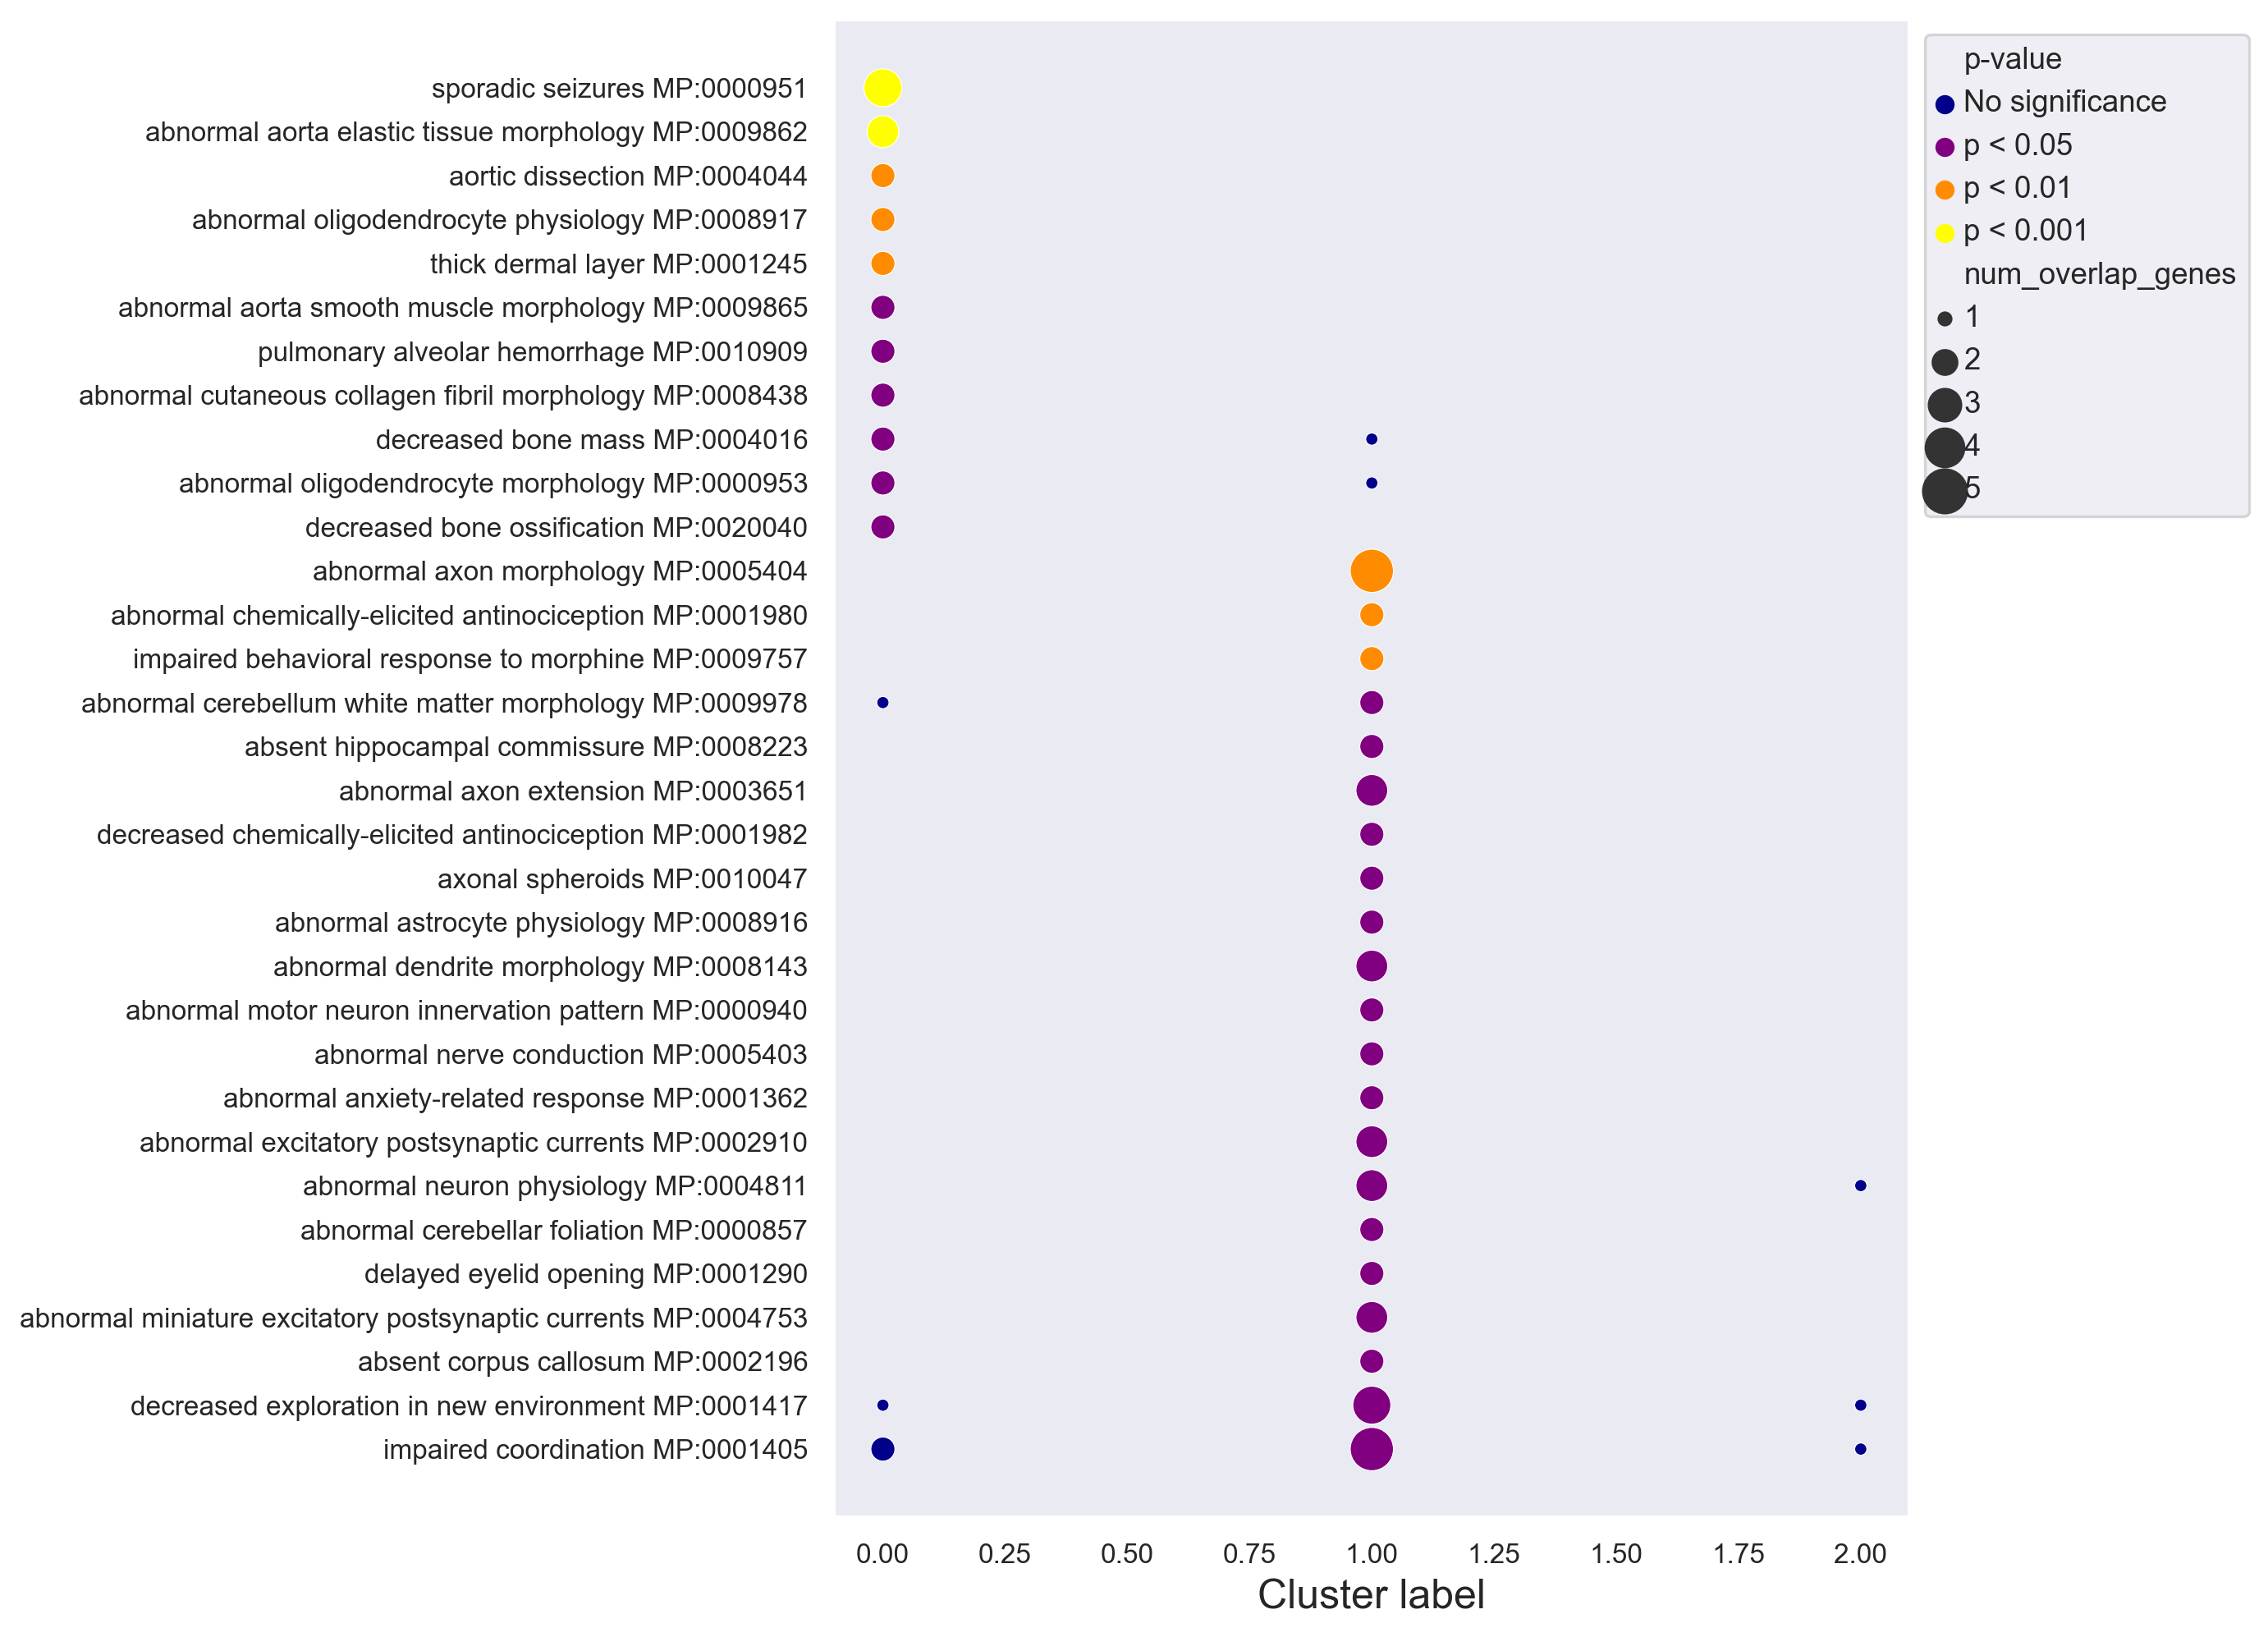

In [58]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [59]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [60]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Collagen Chain Trimerization R-HSA-8948216,1,0.000353,92.676768,736.691307,"[COL1A1, COL3A1]",0.019239,0,0,2,1.715828,0
Scavenging By Class A Receptors R-HSA-3000480,2,0.000353,92.676768,736.691307,"[COL1A1, COL3A1]",0.019239,0,0,2,1.715828,0
Binding And Uptake Of Ligands By Scavenger Receptors R-HSA-2173782,3,0.001084,49.021390,334.690510,"[COL1A1, COL3A1]",0.032758,0,0,2,1.484685,0
Assembly Of Collagen Fibrils And Other Multimeric Structures R-HSA-2022090,4,0.001202,46.292929,311.258295,"[COL1A1, COL3A1]",0.032758,0,0,2,1.484685,0
Collagen Biosynthesis And Modifying Enzymes R-HSA-1650814,5,0.001735,37.859504,240.659695,"[COL1A1, COL3A1]",0.037827,0,0,2,1.422202,0


In [62]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

5

In [63]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

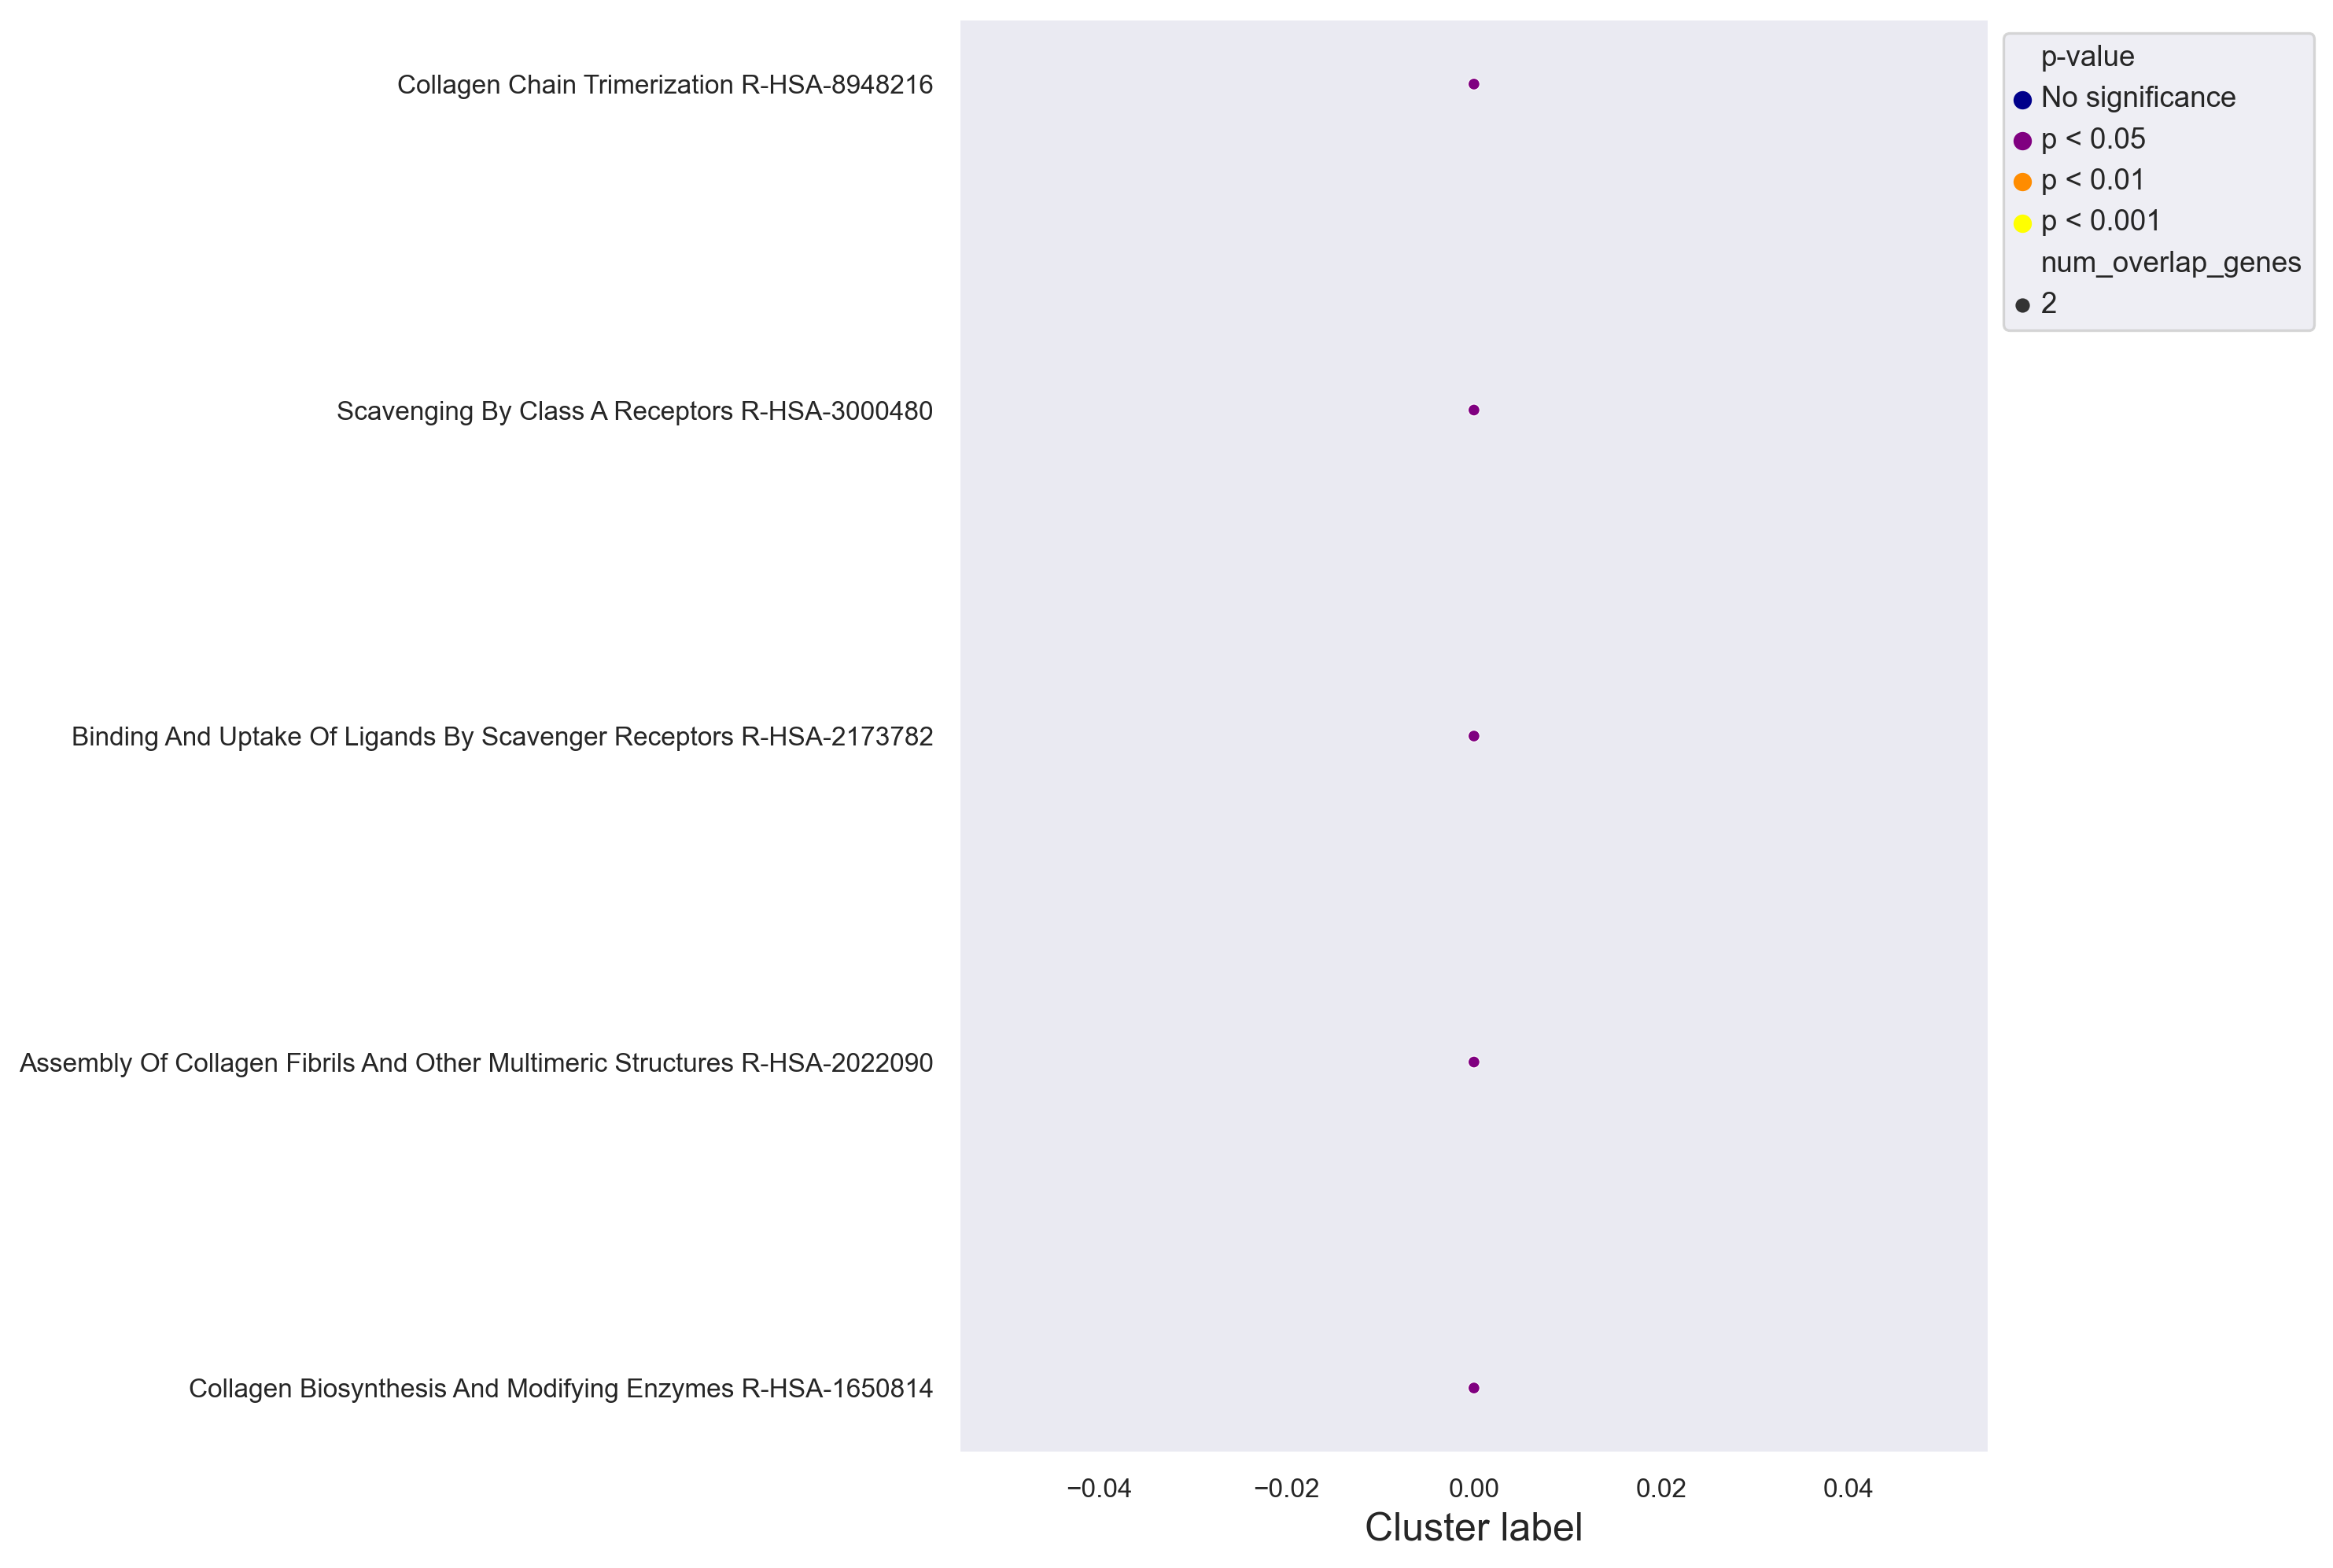

In [64]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [65]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [66]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Relaxin signaling pathway,1,0.001336,15.857143,104.947284,"[ACTA2, COL1A1, COL3A1]",0.059034,0,0,3,1.228897,0
Protein digestion and absorption,2,0.002361,32.020979,193.679429,"[COL1A1, COL3A1]",0.059034,0,0,2,1.228897,0
Diabetic cardiomyopathy,3,0.005083,9.721805,51.349307,"[COL1A1, COL3A1, SLC2A1]",0.065524,0,0,3,1.183603,0
Amoebiasis,4,0.006020,19.325581,98.805818,"[COL1A1, COL3A1]",0.065524,0,0,2,1.183603,0
Adipocytokine signaling pathway,5,0.006552,18.462626,92.828804,"[NPY, SLC2A1]",0.065524,0,0,2,1.183603,0


In [67]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0

In [68]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\aleks\AppData\Local\Temp\ipykernel_13700\3967478431.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


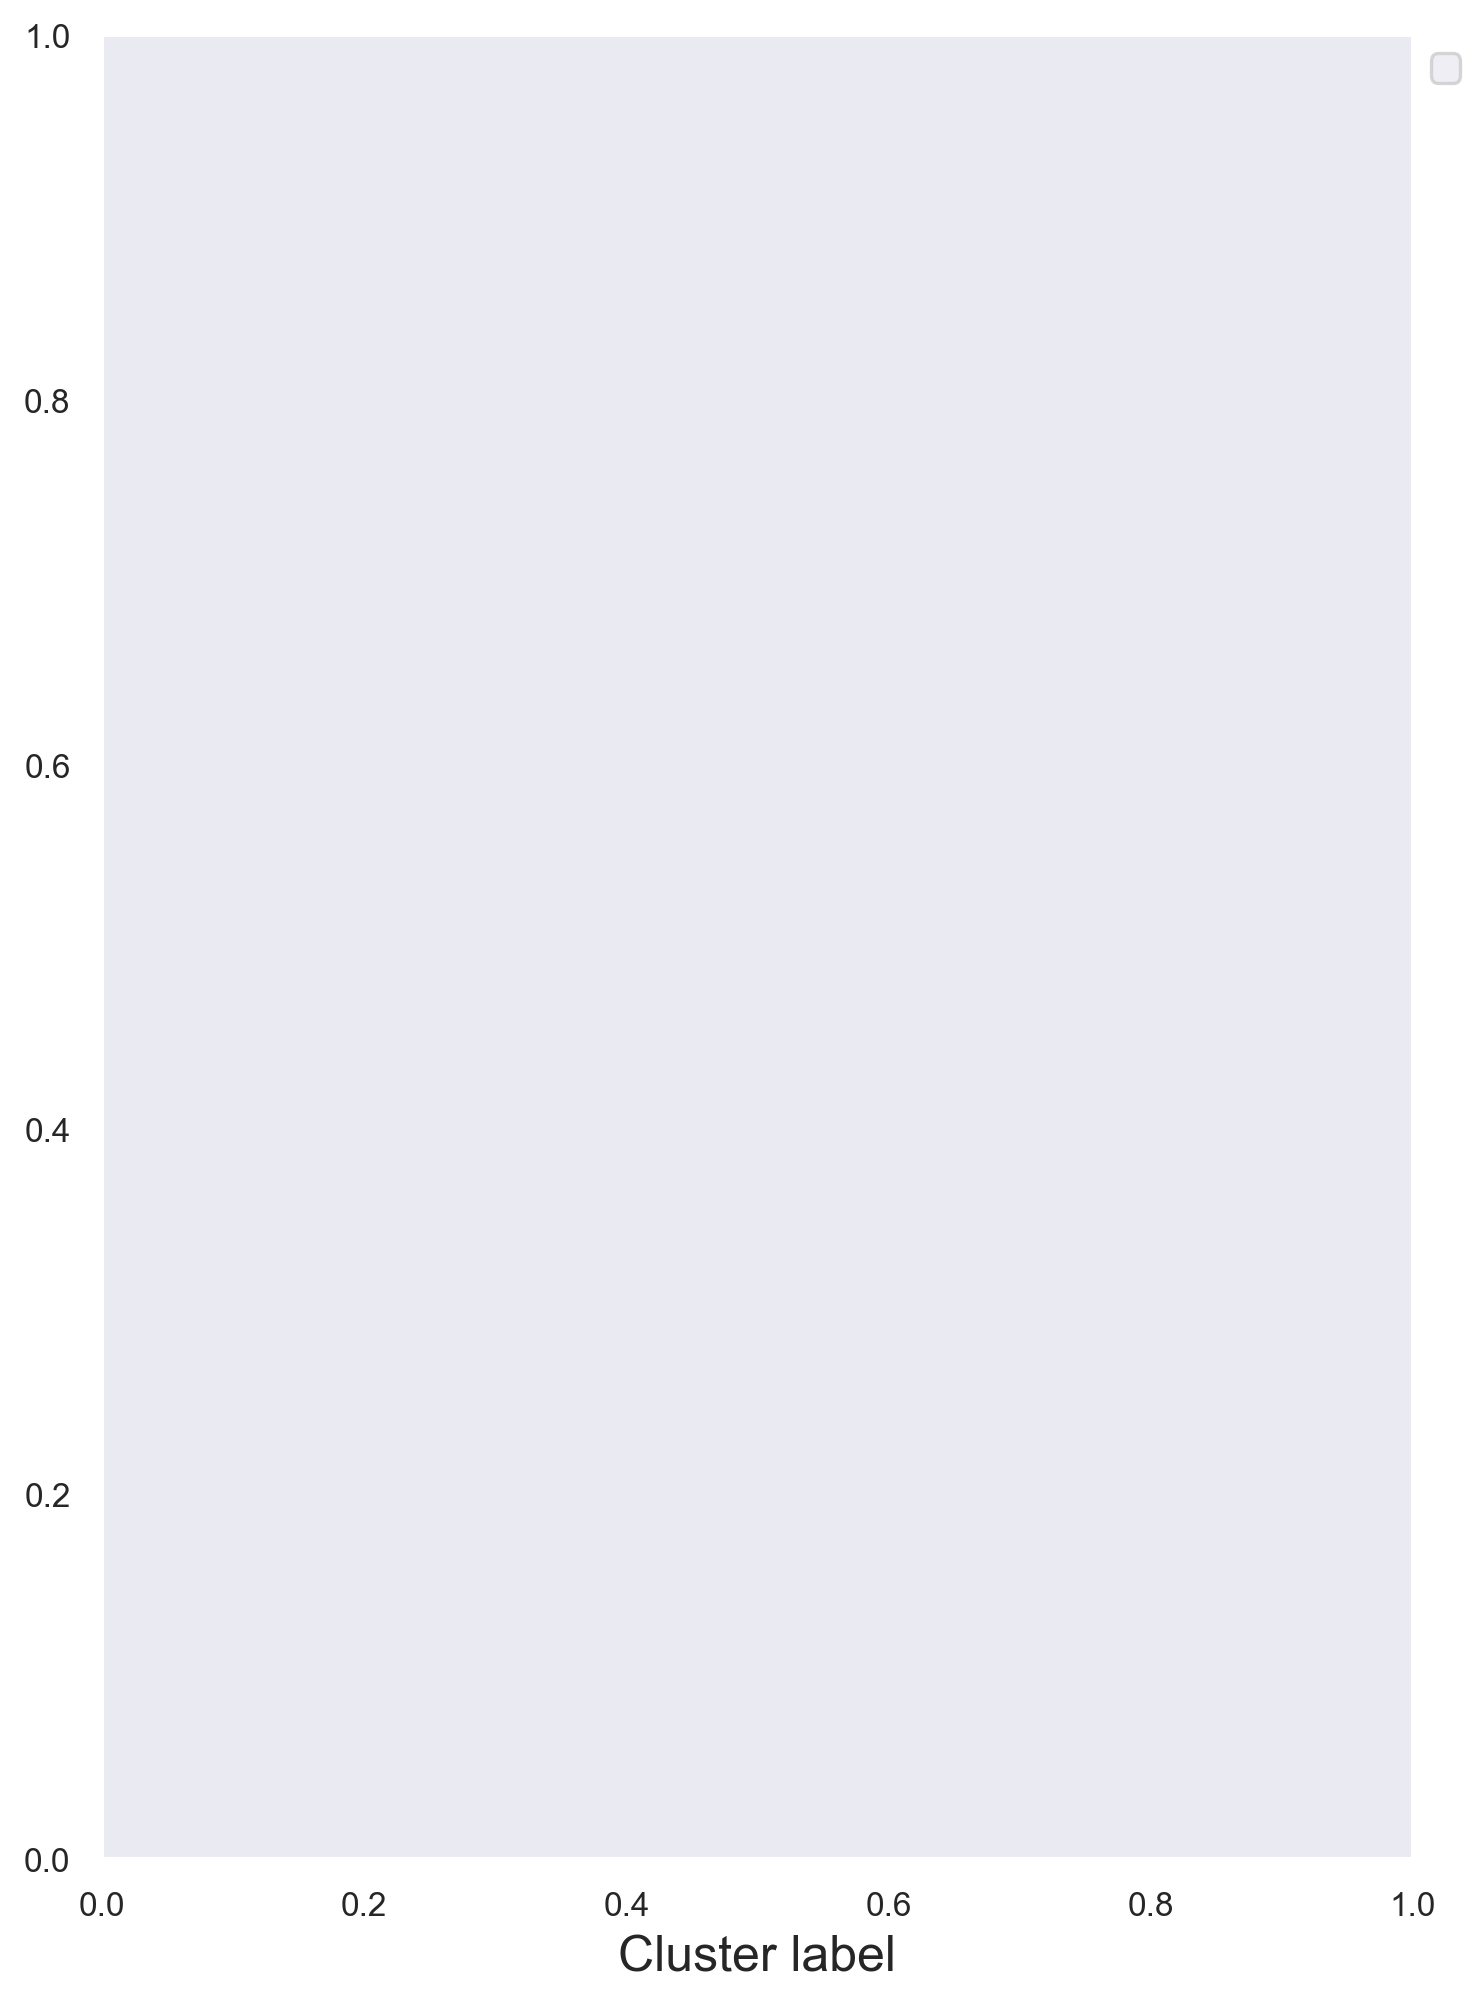

In [69]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))